In [1]:
# data manipulation
import pandas as pd
import numpy as np
from datetime import timezone, timedelta, time, datetime

# stats liibs
from scipy import stats
from scipy.stats import pearsonr

# data viz
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# apply some cool styling
plt.style.use("seaborn-darkgrid")
rcParams['figure.figsize'] = (12,  6)
sns.set(font_scale=1.5)

# make reproducible
np.random.seed(42)

# dataset
wildfire = 'https://bit.ly/3fVhoGZ'

# Portugal Districts
# Center   = ['Castelo Branco', 'Viseu', 'Guarda', 'Aveiro', 'Coimbra', 'Leiria']
# Algarve  = ['Faro']
# Alentejo = ['Évora', 'Beja', 'Portalegre', 'Santarém']
# Lisbon   = ['Lisboa', 'Setúbal']
# Northen  = ['Viana Do Castelo', 'Porto', 'Braga', 'Vila Real', 'Bragança']

North    = ['Porto', 'Vila Real']

# Six-Step Statistical Investigation Method

* Define|Ask a Research Question
* Design a study and collect Data (Step will be skipped)
* Explore the Data
* Draw inferences
* Formulate Conclusions
* Look back & ahead

## 1. Define|Ask a Research Question

### Do the Porto and Vila Real Districts have the same characteristics regarding Fire Typology, Fire Causes, Temporal Incidence (Weekday and Month), Fire Duration and Burnt Area?

### Variables to be used: 

    * Qualitative Variables (Categorical data): 
        - Tipo: wildfire type: “Florestal, Agrícola, Falso Alarme, Queimada” 
        - Distrito: Administrative areas 
        - TipoCausa: Source – “Intencional, Natural, Negligente, Desconhecida, Reacendimento, NULL” 

    * Quantitative Variables (Numerical data) 
        - DataAlerta: Communication date 
        - HoraAlerta: Communication hour 
        - DataExtinção: Extinction date 
        - HoraExtinção: Extinction hour 
        - AA_Total (pov+mato+agric) (ha): Total burned area 



## 2. Explore the Data (Data Cleaning & Filtering)

In [2]:
# Load dataset
df = pd.read_csv(wildfire, sep=';')
df.head()

,Ano,Codigo SGIF,Codigo_ANPC,Tipo,Distrito,Concelho,Freguesia,Local,INE,x,...,Falso Alarme,Fogacho,Incendio,Agricola,Perimetro,APS,Causa,TipoCausa,Região PROF,UGF
0,2015,DM315252,2015160007544,Florestal,Viana do Castelo,Ponte de Lima,Serdedelo,VALE DE TROVELA (SERDEDELO),160746,167814,...,0,0,1,0,NaN,NaN,122.0,Negligente,Entre Douro e Minho,Alto Minho
1,2015,DM215305,2015130043758,Florestal,Porto,Marco de Canaveses,Vila Boa de Quires,LUGAR DO FOFO,130731,193731,...,0,0,1,0,NaN,NaN,122.0,Negligente,Entre Douro e Minho,Tâmega
2,2015,DM415293,2015030021973,Florestal,Braga,Vila Verde,Lage,RUA PROF ABEL MADEIRA,31323,172162,...,0,1,0,0,NaN,NaN,60.0,Desconhecida,Entre Douro e Minho,Baixo Minho
3,2015,DM315261,2015160007563,Falso Alarme,Viana do Castelo,Ponte de Lima,Boalhosa,J. DEPOSITOS DE AGUA (BOALHOSA),160709,171291,...,1,0,0,0,NaN,NaN,630.0,Desconhecida,Entre Douro e Minho,Alto Minho
4,2015,BL115321,2015180015874,Agrícola,Viseu,Castro Daire,Castro Daire,Farejinhas - Bº das Queirós,180304,217299,...,0,1,0,0,NaN,NaN,630.0,Desconhecida,Beira Litoral,Dão Lafões


In [3]:
# Inspecting dataset colunms name
df.columns

Index(['Ano', 'Codigo SGIF', 'Codigo_ANPC', 'Tipo', 'Distrito', 'Concelho',
       'Freguesia', 'Local', 'INE', 'x', 'y', 'lat', 'lon', 'DataAlerta',
       'HoraAlerta', 'DataExtincao', 'HoraExtincao', 'Data1Intervencao',
       'Hora1Intervencao', 'FonteAlerta', 'NUT', 'AA_Povoamento (ha)',
       'AA_Mato (ha)', 'AA_Agricola (ha)',
       'AA_EspacosFlorestais (pov+mato)(ha)', 'AA_Total (pov+mato+agric) (ha)',
       'Reacendimentos', 'Queimada', 'Falso Alarme', 'Fogacho', 'Incendio',
       'Agricola', 'Perimetro', 'APS', 'Causa', 'TipoCausa', 'Região PROF',
       'UGF'],
      dtype='object')

In [4]:
# Inspecting colunms with null values
display(df[df.columns[df.isnull().any()]].isnull().sum(axis=0))

Local                   1
DataExtincao          312
HoraExtincao          317
Data1Intervencao     1199
Hora1Intervencao     1213
FonteAlerta         23175
Perimetro           22349
APS                 22116
Causa                7013
TipoCausa            7013
Região PROF             2
UGF                     1
dtype: int64

In [5]:
# Inspecting dataset shape
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns. ')

The dataset has 23175 rows and 38 columns. 


In [6]:
# Inspecting columns datatype
df[['DataAlerta','HoraAlerta', 'DataExtincao', 'HoraExtincao']].dtypes

DataAlerta      object
HoraAlerta      object
DataExtincao    object
HoraExtincao    object
dtype: object

In [7]:
# Converting Date Columens to datetime
df['DAlert'] = df['DataAlerta'].str[:10].astype(str) + ' ' + df['HoraAlerta'].astype(str)
df['DExtiction'] = df['DataExtincao'].str[:10].astype(str) + ' ' + df['HoraExtincao'].astype(str)

df[['DAlert', 'DExtiction']] = df[['DAlert', 'DExtiction']].apply(pd.to_datetime, errors='coerce')

# Inspecting columns datatype
print(df[['DAlert', 'DExtiction']].dtypes)

# Inspecting first rows
df[['DAlert', 'DExtiction']].head()

DAlert        datetime64[ns]
DExtiction    datetime64[ns]
dtype: object


,DAlert,DExtiction
0,2015-03-24 17:01:00,2015-03-24 18:09:00
1,2015-03-24 17:10:00,2015-03-24 18:47:00
2,2015-03-24 19:15:00,2015-03-24 20:00:00
3,2015-03-24 20:05:00,2015-03-24 21:30:00
4,2015-03-24 20:10:00,2015-03-24 21:00:00


In [8]:
# Columns for analysis
columns = ['Distrito','Tipo', 'TipoCausa', 'DAlert','DExtiction','AA_Total (pov+mato+agric) (ha)']
names   = ['District','Type', 'TypeCause', 'DateAlert', 'DateExtinction','AreaTotal']

# Filter the dataset
filtered = df[columns].query('Distrito in @North')

# Reset & drop Indexes
filtered.reset_index(inplace=True, drop=True)

# Renaming columns
filtered.columns = names
filtered.head()

,District,Type,TypeCause,DateAlert,DateExtinction,AreaTotal
0,Porto,Florestal,Negligente,2015-03-24 17:10:00,2015-03-24 18:47:00,"1,35"
1,Vila Real,Florestal,Negligente,2015-03-24 21:40:00,2015-03-25 05:45:00,"38,5"
2,Porto,Florestal,NaN,2015-03-25 15:30:00,2015-03-25 18:25:00,"0,05"
3,Vila Real,Florestal,Negligente,2015-03-25 16:00:00,2015-03-25 17:00:00,"0,01"
4,Vila Real,Florestal,Negligente,2015-03-25 16:40:00,2015-03-25 18:00:00,"0,02"


In [9]:
# Inspecting Type of Fire
display(filtered.Type.value_counts(normalize=True))

Florestal       0.853840
Falso Alarme    0.101435
Agrícola        0.041857
Queimada        0.002869
Name: Type, dtype: float64

In [10]:
# Inspecting new dataset shape
print(f'The dataset has {filtered.shape[0]} rows and {filtered.shape[1]} columns. ')
print(f'Filtered dataframe accounts for {round(filtered.shape[0]/df.shape[0]*100, 2)}% of source')

The dataset has 5925 rows and 6 columns. 
Filtered dataframe accounts for 25.57% of source


In [11]:
# Inspecting colunms with null values
display(filtered[filtered.columns[filtered.isnull().any()]].isnull().sum(axis=0))

TypeCause         2676
DateExtinction      25
dtype: int64

In [12]:
# Inspecting whether the date of Alert is greater that Extinction
display(filtered[(filtered.DateAlert > filtered.DateExtinction) == True])

,District,Type,TypeCause,DateAlert,DateExtinction,AreaTotal
87,Vila Real,Florestal,Intencional,2015-03-06 16:39:00,2015-03-06 00:00:00,6
789,Vila Real,Florestal,Negligente,2015-05-17 11:52:00,2015-05-17 00:23:00,21
3252,Vila Real,Florestal,NaN,2015-08-15 20:56:00,2015-08-15 02:20:00,"2,5"
3769,Vila Real,Florestal,Negligente,2015-07-21 19:09:00,2015-07-21 02:05:00,"1,5"
4029,Vila Real,Florestal,Desconhecida,2015-07-11 20:43:00,2015-07-11 02:30:00,"0,14"


In [13]:
# Removing rows where date of Alert is greater that Extinction
filtered = filtered[(filtered.DateAlert > filtered.DateExtinction) == False].copy(deep=True)
display(filtered[(filtered.DateAlert > filtered.DateExtinction) == True])

,District,Type,TypeCause,DateAlert,DateExtinction,AreaTotal


In [14]:
# Calculating time of fire and getting day of week

filtered['FireDuration']   = filtered.DateExtinction - filtered.DateAlert
filtered['DayAlert']       = filtered.DateAlert.dt.day_name()
filtered['Month']          = filtered.DateExtinction.dt.month_name().str[:3]
filtered['HourTotal']      = filtered.FireDuration / pd.Timedelta(1, 'h')
filtered['DayOfYear']      = filtered.DateAlert.dt.day_of_year
filtered['HourOfDay']      = filtered.DateAlert.dt.hour

# Converting AreaTotal to integer
filtered['AreaTotal'] = filtered['AreaTotal'].str.replace(',', '.').astype('float')


In [15]:
filtered.head()

,District,Type,TypeCause,DateAlert,DateExtinction,AreaTotal,FireDuration,DayAlert,Month,HourTotal,DayOfYear,HourOfDay
0,Porto,Florestal,Negligente,2015-03-24 17:10:00,2015-03-24 18:47:00,1.35,0 days 01:37:00,Tuesday,Mar,1.616667,83,17
1,Vila Real,Florestal,Negligente,2015-03-24 21:40:00,2015-03-25 05:45:00,38.50,0 days 08:05:00,Tuesday,Mar,8.083333,83,21
2,Porto,Florestal,NaN,2015-03-25 15:30:00,2015-03-25 18:25:00,0.05,0 days 02:55:00,Wednesday,Mar,2.916667,84,15
3,Vila Real,Florestal,Negligente,2015-03-25 16:00:00,2015-03-25 17:00:00,0.01,0 days 01:00:00,Wednesday,Mar,1.000000,84,16
4,Vila Real,Florestal,Negligente,2015-03-25 16:40:00,2015-03-25 18:00:00,0.02,0 days 01:20:00,Wednesday,Mar,1.333333,84,16


In [16]:
print("TypeCause  Numbers")
display(filtered.TypeCause.value_counts(dropna=False, ascending=False, normalize=True))
print("Type Numbers")
display(filtered.Type.value_counts(dropna=False, ascending=False, normalize=True))


TypeCause  Numbers


NaN              0.451858
Negligente       0.222973
Desconhecida     0.126351
Intencional      0.103209
Reacendimento    0.093750
Natural          0.001858
Name: TypeCause, dtype: float64

Type Numbers


Florestal       0.853716
Falso Alarme    0.101520
Agrícola        0.041892
Queimada        0.002872
Name: Type, dtype: float64

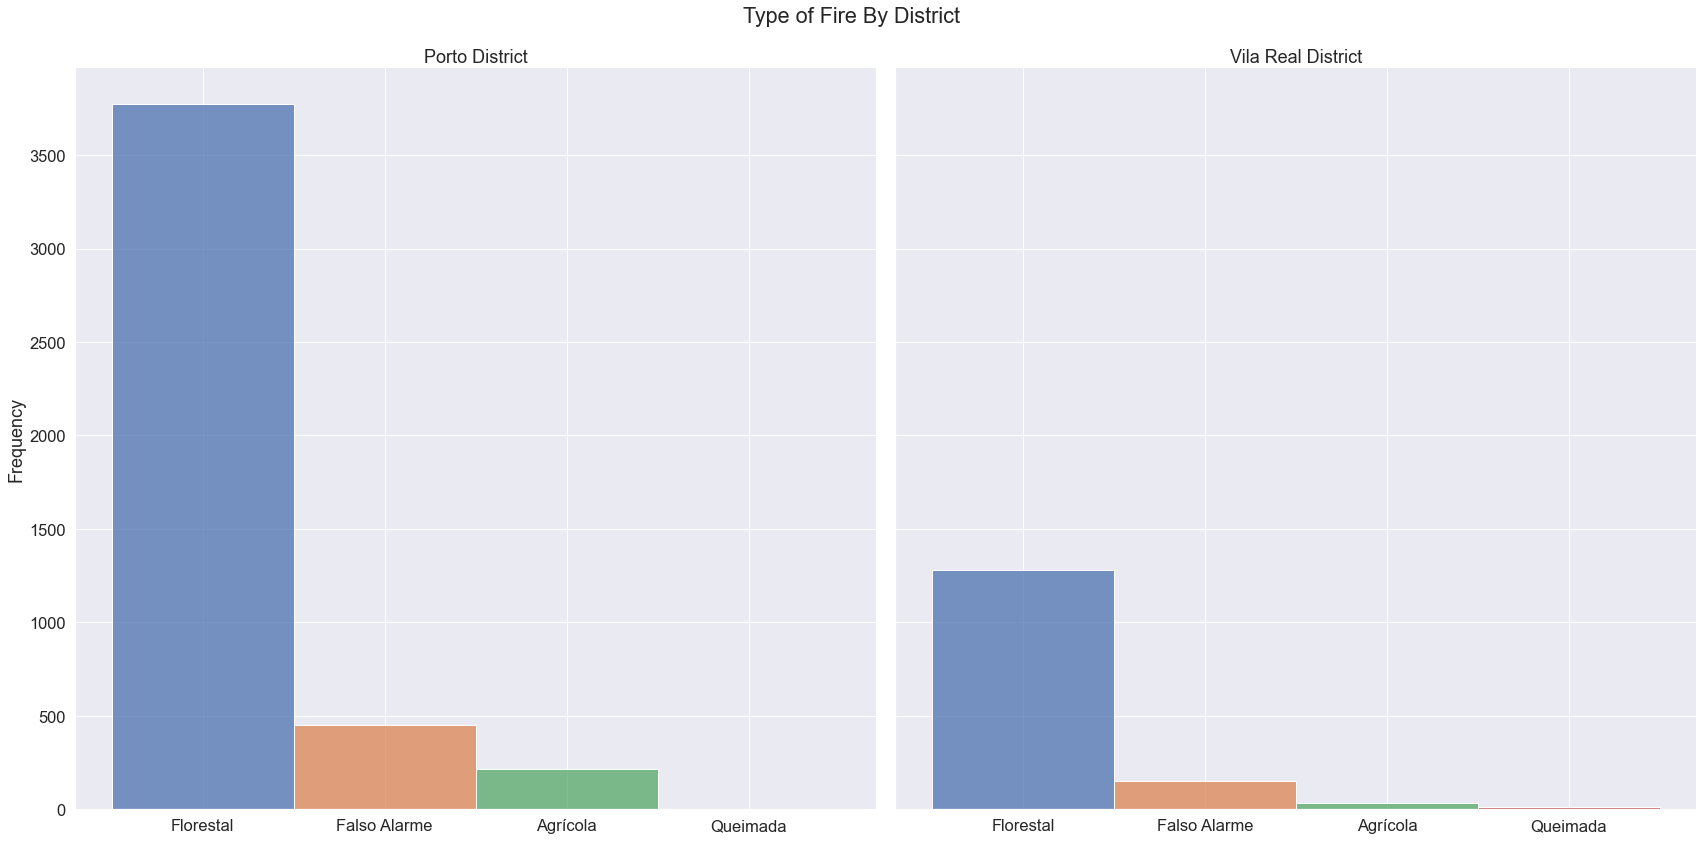

In [17]:
g = sns.FacetGrid(filtered, col="District", height= 12, hue="Type")
g.map_dataframe(sns.histplot, x="Type")
g.set_axis_labels("", "Frequency")
g.set_titles(col_template="{col_name} District", row_template="{row_name}")
g.fig.suptitle("Type of Fire By District")
g.tight_layout();

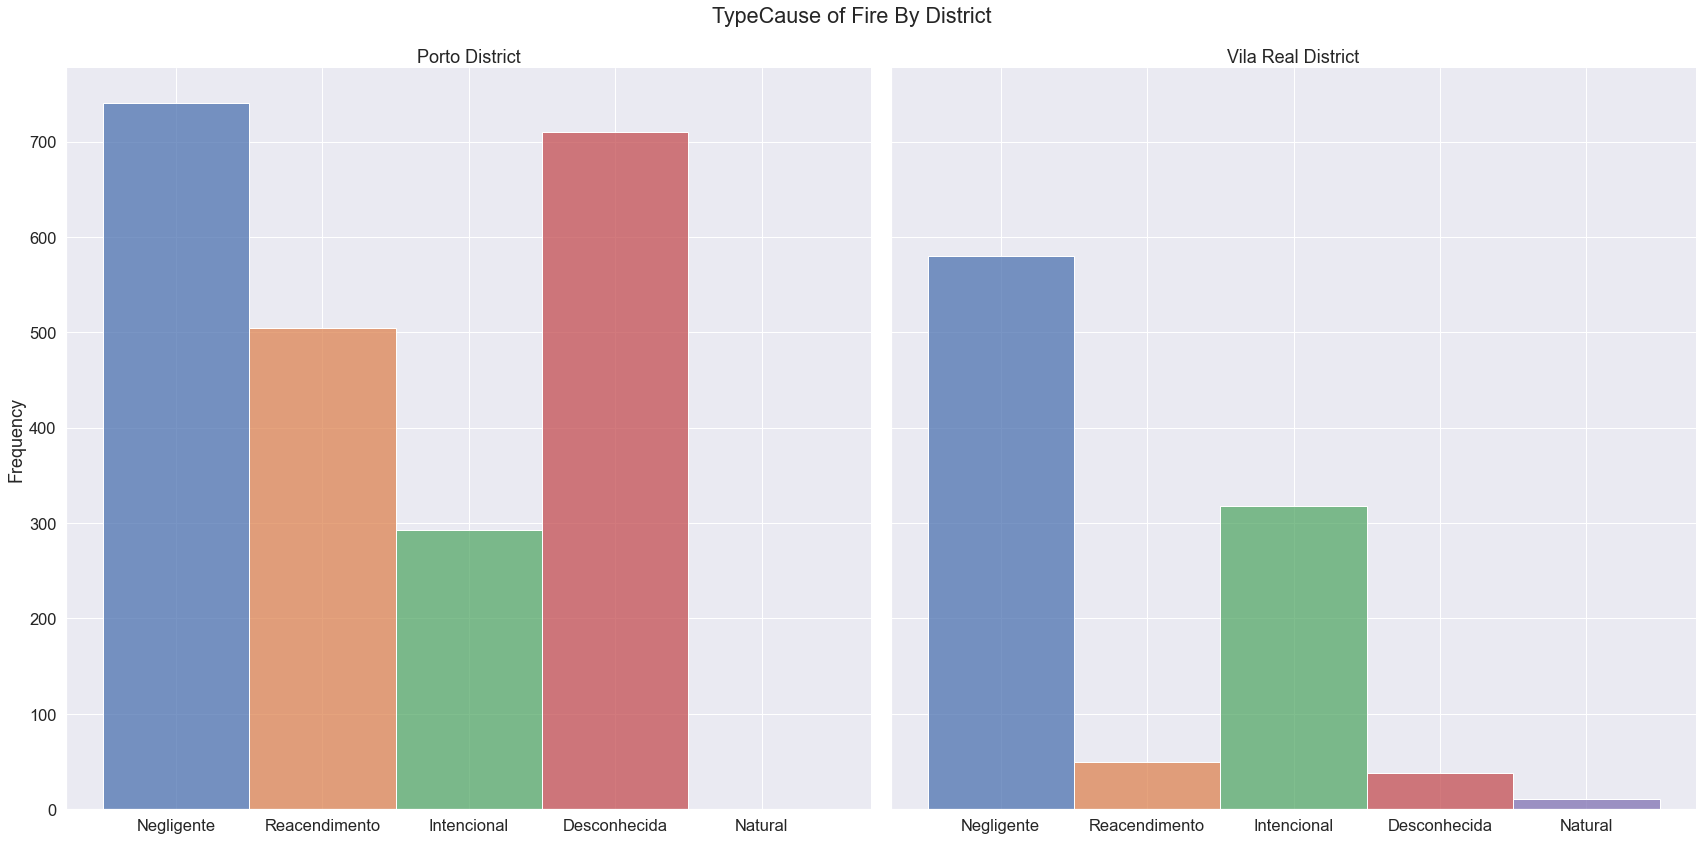

In [18]:
g = sns.FacetGrid(filtered, col="District", height= 12, hue="TypeCause")
g.map_dataframe(sns.histplot, x="TypeCause")
g.set_axis_labels("", "Frequency")
g.set_titles(col_template="{col_name} District", row_template="{row_name}")
g.fig.suptitle("TypeCause of Fire By District")
g.tight_layout();

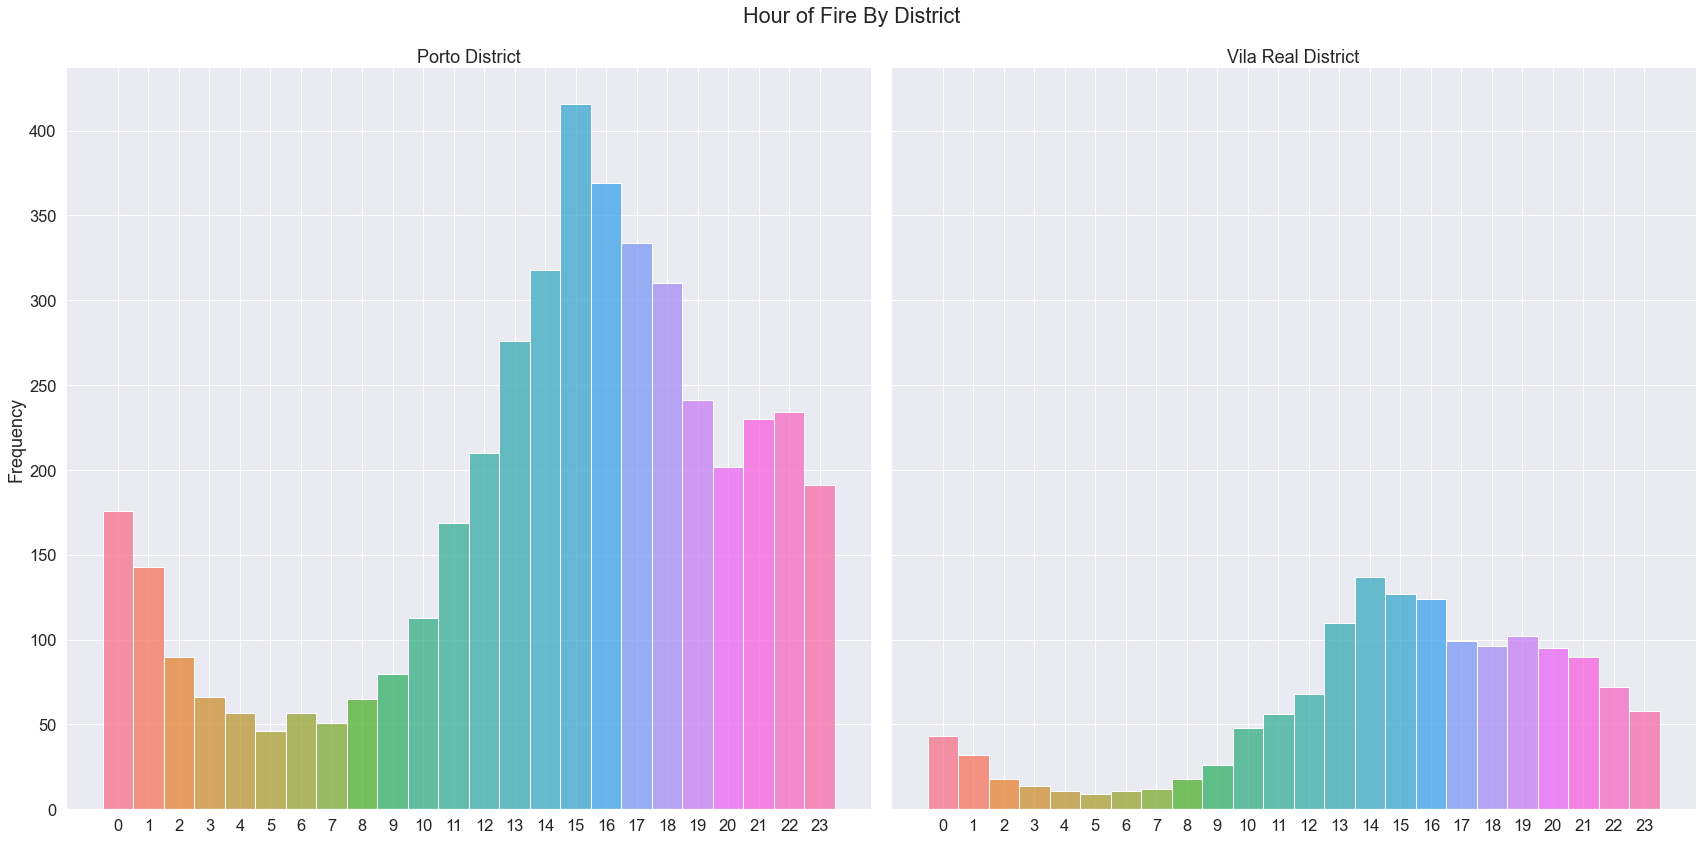

In [19]:
g = sns.FacetGrid(filtered, col="District", height= 12, hue="HourOfDay")
g.map_dataframe(sns.histplot, x="HourOfDay")
g.set_axis_labels("", "Frequency")
g.set_titles(col_template="{col_name} District", row_template="{row_name}")
g.fig.suptitle("Hour of Fire By District")
g.set(xticks=np.arange(0,24,1))
g.set_xticklabels(np.arange(0,24,1))
g.tight_layout();

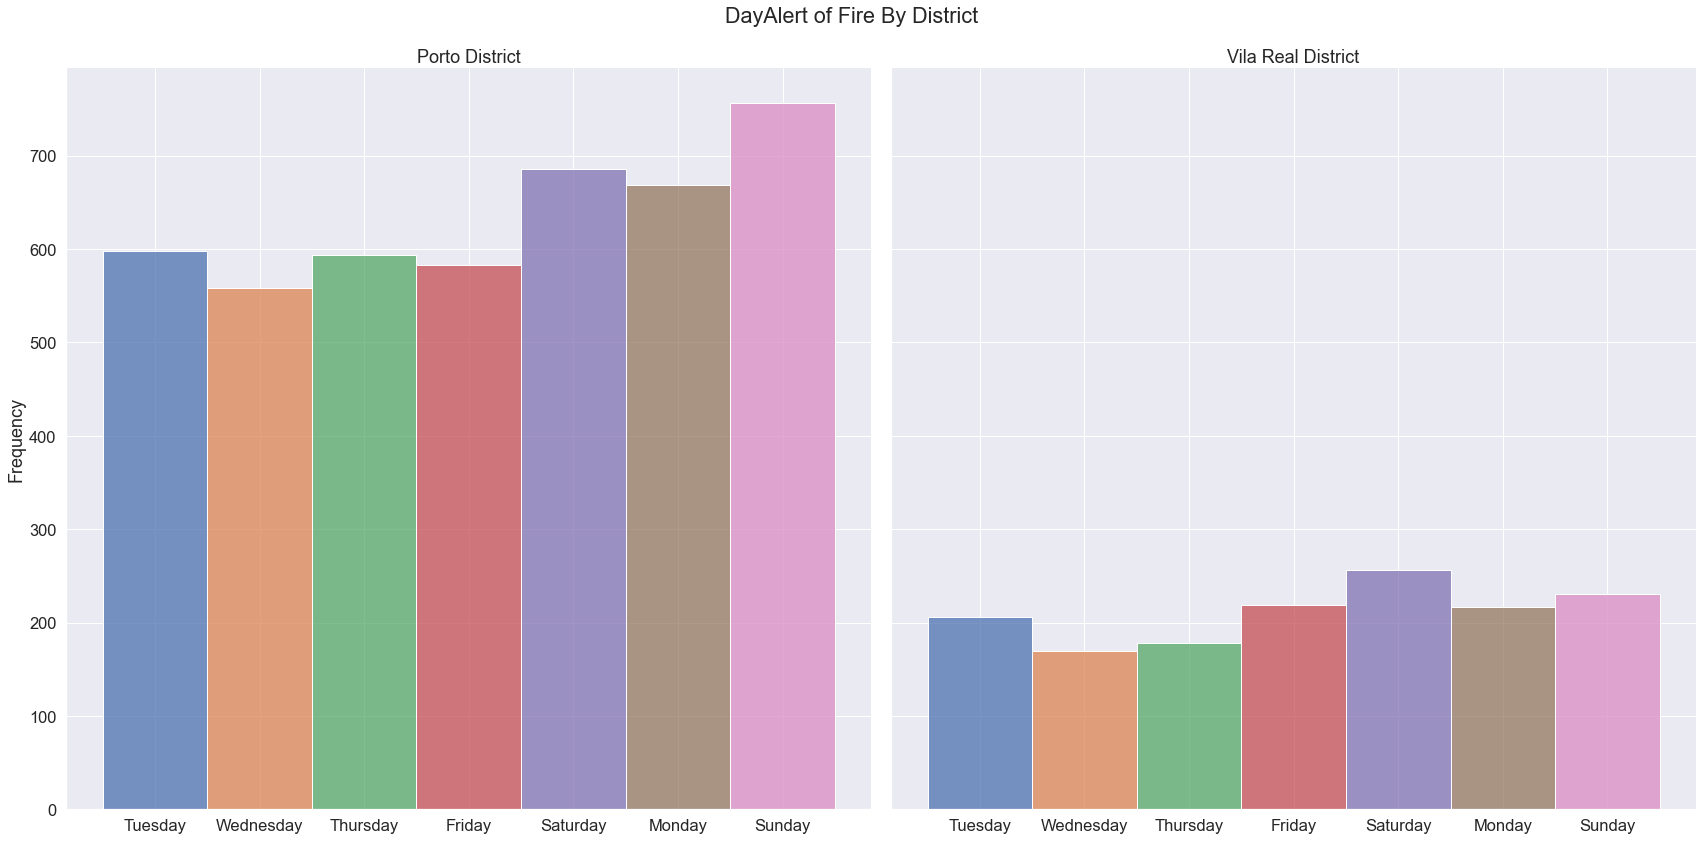

In [20]:
#['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

g = sns.FacetGrid(filtered, col="District", height= 12, hue="DayAlert")
g.map_dataframe(sns.histplot, x="DayAlert")
g.set_axis_labels("", "Frequency")
g.set_titles(col_template="{col_name} District", row_template="{row_name}")
g.fig.suptitle("DayAlert of Fire By District")
g.tight_layout();

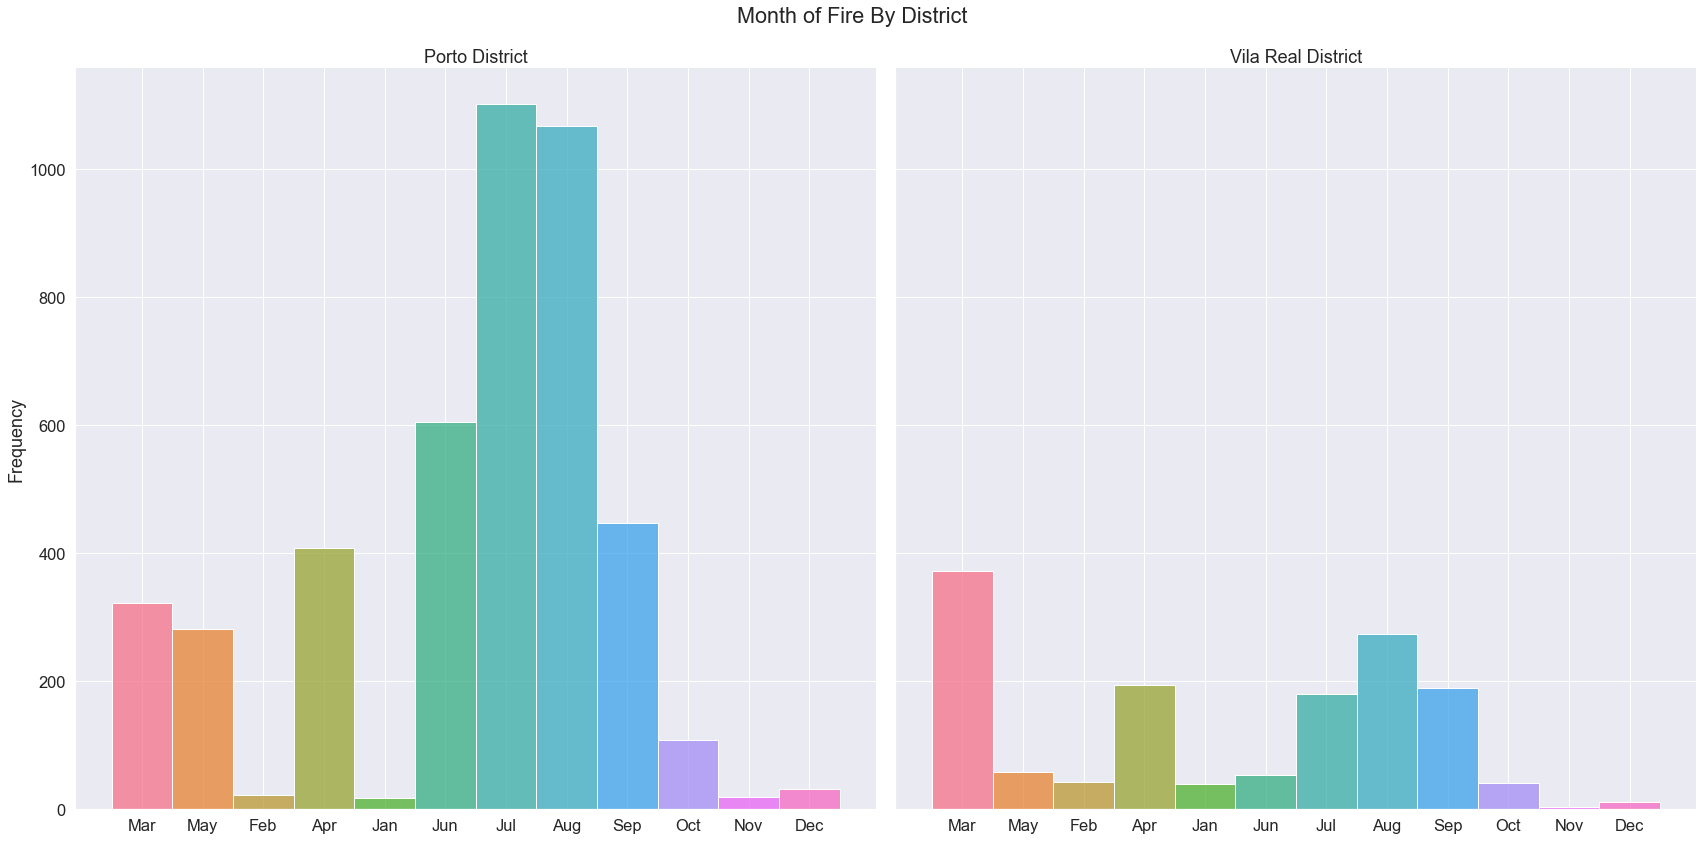

In [21]:
g = sns.FacetGrid(filtered, col="District", height= 12, hue="Month")
g.map_dataframe(sns.histplot, x="Month")
g.set_axis_labels("", "Frequency")
g.set_titles(col_template="{col_name} District", row_template="{row_name}")
g.fig.suptitle("Month of Fire By District")
g.tight_layout();

In [22]:
burnArea = filtered.groupby('District')['AreaTotal'].agg('sum')

burnArea

District
Porto        2545.8578
Vila Real    5587.4990
Name: AreaTotal, dtype: float64

In [26]:
burnAreaType = filtered.query('AreaTotal > 0').groupby(['District','Type'])['AreaTotal'].sum().reset_index(name='totalArea')
burnAreaType

,District,Type,totalArea
0,Porto,Agrícola,18.4495
1,Porto,Florestal,2527.3423
2,Porto,Queimada,0.0660
3,Vila Real,Agrícola,8.6800
4,Vila Real,Florestal,5575.1930
5,Vila Real,Queimada,3.6260


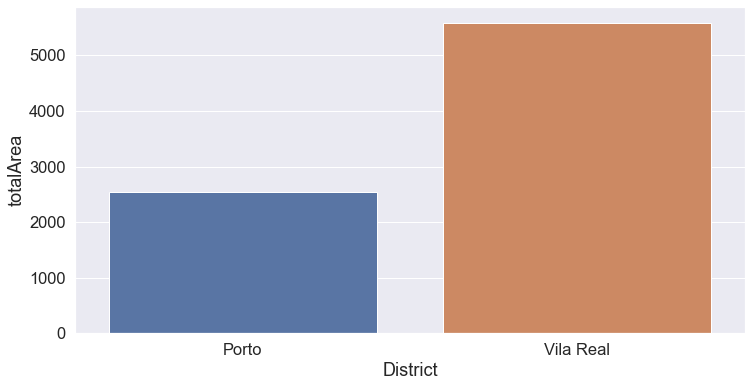

In [27]:
burnArea = filtered.query('AreaTotal > 0').groupby('District')['AreaTotal'].sum().reset_index(name='totalArea')

sns.barplot(x="District", y='totalArea', data=burnArea);

In [25]:
filtered.dtypes

District                   object
Type                       object
TypeCause                  object
DateAlert          datetime64[ns]
DateExtinction     datetime64[ns]
AreaTotal                 float64
FireDuration      timedelta64[ns]
DayAlert                   object
Month                      object
HourTotal                 float64
DayOfYear                   int64
HourOfDay                   int64
dtype: object